In [19]:
%load_ext autoreload
%autoreload 2
import torch
from modules.competition_dataset_new import EEGDataset, LABELS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.covariance import EmpiricalCovariance
import random
import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_classif
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score
from scipy.stats import wasserstein_distance

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

In [4]:
data_path = './data/mtcaic3'
lda_model_path = './checkpoints/mi/models/lda_mi.pkl'

# Add this at the beginning of your notebook, after imports
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_random_seeds(42)

In [12]:
eeg_channels = [
    "C3",  # 2296.15
    "PZ",  # 1744.43
    "C4",  # 1556.46
    "OZ",  # 444.98
    "PO7",  # 381.63
    "PO8",  # 275.78
    "CZ",  # 200.43
    "FZ",  # 111.51
]


dataset_train = EEGDataset(
    data_path=data_path,
    task="MI",
    split="train",
    tmin=0.5,  # skip first 0.5 s (125 samples)
    win_len=int(4.5 * 250),  # 4.5 s window → 1125 samples
    eeg_channels=eeg_channels,
    read_labels=True,
    hardcoded_mean=False,
)

dataset_val = EEGDataset(
    data_path="./data/mtcaic3",
    task="MI",
    split="validation",
    tmin=0.5,
    win_len=int(4.5 * 250),
    eeg_channels=eeg_channels,
    read_labels=True,
    hardcoded_mean=False,
)

dataset_test = EEGDataset(
    data_path="./data/mtcaic3",
    task="MI",
    split="test",
    tmin=0.5,
    win_len=int(4.5 * 250),
    eeg_channels=eeg_channels,
    read_labels=False,
    hardcoded_mean=False,
)

In [21]:
dataset_train[0][0].shape

torch.Size([8, 1125])

In [13]:
all_data = torch.cat([torch.stack([x for x,_ in ds]) for ds in (dataset_train, dataset_val, dataset_test)])
X_val_train = torch.cat([torch.stack([x for x,_ in ds]) for ds in (dataset_train, dataset_val)])
y_val_train = torch.cat([torch.stack([y for _,y in ds]) for ds in (dataset_train, dataset_val)])

mean = all_data.mean((0, 2))
std = all_data.std((0, 2))

X_val_train = (X_val_train - mean[None, :, None]) / std[None, :, None]

mean, std

(tensor([ 0.1557,  0.2455,  0.3131,  0.3464,  0.2734, -0.0244,  0.0947,  0.0542]),
 tensor([2588.6677, 1692.9707, 3939.0535, 1979.3948, 2239.5142, 1133.0498,
         1417.5095, 1076.2388]))

In [14]:
# F score to reveal most relevant features
num_samples, num_channels, time_points = X_val_train.shape
original_channel_names = ["FZ","C3","CZ","C4","PZ","PO7","OZ","PO8"]

print(f"Data shape for selection: {X_val_train.shape}, Labels shape: {y_val_train.shape}")

channel_f_scores = []

print("\nCalculating F-scores for each channel...")
for i in range(num_channels):
    channel_data = X_val_train[:, i, :]
    
    f_scores_per_timepoint, _ = f_classif(channel_data, y_val_train)
    
    aggregated_f_score = np.sum(f_scores_per_timepoint)
    channel_f_scores.append(aggregated_f_score)

channel_scores_dict = {original_channel_names[i]: channel_f_scores[i] for i in range(num_channels)}

print("\n--- F-scores for each channel (higher score indicates more informativeness) ---")
sorted_channels = sorted(channel_scores_dict.items(), key=lambda item: item[1], reverse=True)
for channel, score in sorted_channels:
    print(f"  {channel}: {score:.2f}")

top_3_channels = [channel for channel, score in sorted_channels[:3]]
print(f"\n--- Recommended Top 3 Channels based on F-score: {top_3_channels} ---")

Data shape for selection: torch.Size([2450, 8, 1125]), Labels shape: torch.Size([2450])

Calculating F-scores for each channel...

--- F-scores for each channel (higher score indicates more informativeness) ---
  CZ: 4017.45
  FZ: 3797.17
  OZ: 2784.71
  PO7: 2533.00
  PZ: 1594.11
  PO8: 1592.15
  C4: 895.90
  C3: 555.74

--- Recommended Top 3 Channels based on F-score: ['CZ', 'FZ', 'OZ'] ---


Data prepared for t-SNE with shape: (2450, 9000)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2450 samples in 0.011s...
[t-SNE] Computed neighbors for 2450 samples in 1.733s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2450
[t-SNE] Computed conditional probabilities for sample 2000 / 2450
[t-SNE] Computed conditional probabilities for sample 2450 / 2450
[t-SNE] Mean sigma: 11.680208
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.797333
[t-SNE] KL divergence after 1000 iterations: -1.598034
t-SNE completed.


/tmp/ipykernel_40602/1148589758.py:27: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(


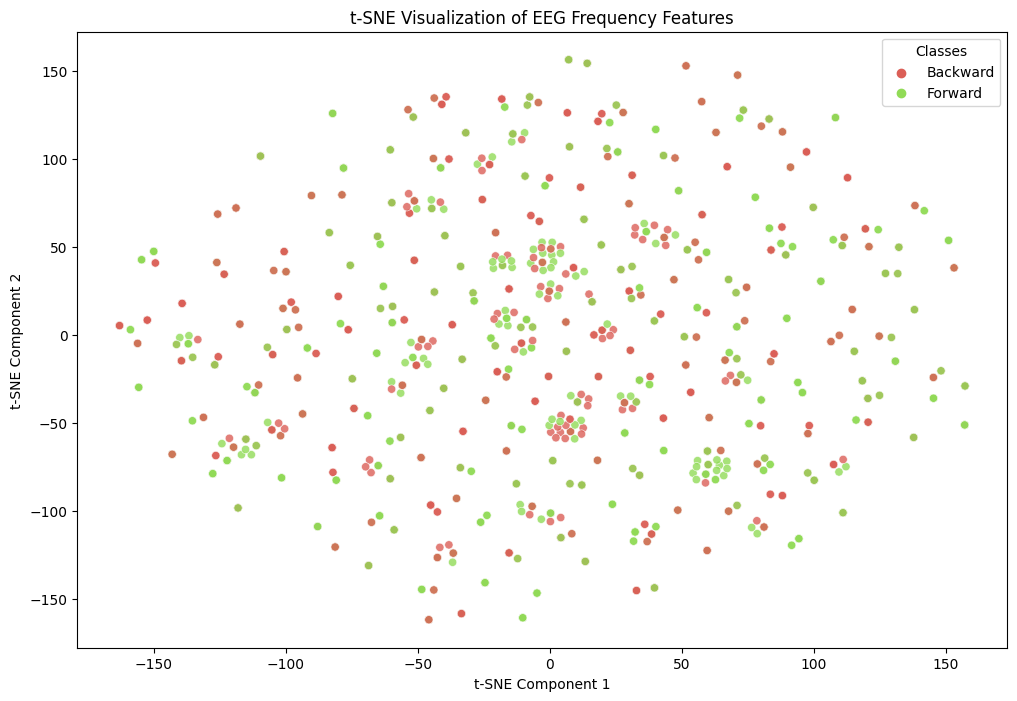

Trustworthiness: 0.9994742683314112
Silhouette (high-D): 0.00025842284
Silhouette (2-D): 0.0006971528


In [15]:
# T-SNE to reveal how separatable the data is
num_batches_for_tsne = 5

all_features = X_val_train[:5000].numpy()
all_labels = y_val_train[:5000].numpy()

n_samples = all_features.shape[0]
flattened_features = all_features.reshape(n_samples, -1) # n_samples x n_channels * n_freq_bins

print(f"Data prepared for t-SNE with shape: {flattened_features.shape}")

tsne = TSNE(
    n_components=2,      # We want a 2D plot
    verbose=1,           # Print progress
    perplexity=30,       # A good default value, relates to # of nearest neighbors
    learning_rate='auto',
    init='pca'
)
tsne_results = tsne.fit_transform(flattened_features)

print("t-SNE completed.")

df_tsne = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])
df_tsne['label'] = [LABELS[l] for l in all_labels] 

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 4), # Use 4 distinct colors for the 4 classes
    data=df_tsne,
    legend="full",
    alpha=0.8 # Set transparency of points
)

plt.title('t-SNE Visualization of EEG Frequency Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes')
plt.show()


X_high = flattened_features            # n_samples × (n_channels*n_freq_bins)
X_low  = tsne_results                  # n_samples × 2
y      = all_labels

# how well local structure is preserved
print("Trustworthiness:", trustworthiness(X_high, X_low, n_neighbors=5))

# cluster separability in the original space
print("Silhouette (high-D):", silhouette_score(X_high, y))

# cluster separability in the embedding
print("Silhouette (2-D):", silhouette_score(X_low, y))

train: 2400, val: 50, test: 50
Wasserstein distance (val vs train):  43.223
Wasserstein distance (test vs train): 22.904


/home/zeyadcode/.pyenv/versions/icmtc_venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zeyadcode/.pyenv/versions/icmtc_venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/zeyadcode/.pyenv/versions/icmtc_venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


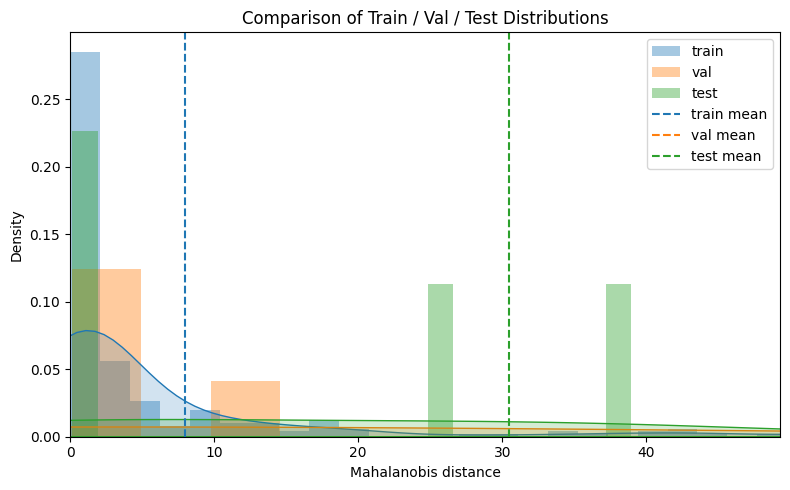

In [20]:
# --- assume dataset_train, dataset_val, dataset_test are already loaded ---

# 1. Fit Empirical Covariance on the mean (across time) of train data
print(f"train: {len(dataset_train.data)}, val: {len(dataset_val.data)}, test: {len(dataset_test.data)}")
ec = EmpiricalCovariance().fit(dataset_train.data.mean(axis=2))

# 2. Compute Mahalanobis distances (mean over time for each sample)
d_train = ec.mahalanobis(dataset_train.data.mean(axis=2))
d_val   = ec.mahalanobis(dataset_val.data.mean(axis=2))
d_test  = ec.mahalanobis(dataset_test.data.mean(axis=2))

# 3. Quantitative closeness: Wasserstein (Earth Mover's) distances
wd_val_train  = wasserstein_distance(d_val,   d_train)
wd_test_train = wasserstein_distance(d_test,  d_train)
print(f"Wasserstein distance (val vs train):  {wd_val_train:.3f}")
print(f"Wasserstein distance (test vs train): {wd_test_train:.3f}")

# 4. Plot density-normalized histograms + KDEs
plt.figure(figsize=(8, 5))

# density histograms
plt.hist(d_train, bins=50, alpha=0.4, density=True, label="train")
plt.hist(d_val,   bins=50, alpha=0.4, density=True, label="val")
plt.hist(d_test,  bins=50, alpha=0.4, density=True, label="test")

# KDE overlays
sns.kdeplot(d_train, fill=True, alpha=0.2)
sns.kdeplot(d_val,   fill=True, alpha=0.2)
sns.kdeplot(d_test,  fill=True, alpha=0.2)

# 5. Zoom x-axis to 95th percentile to improve visibility
all_d = np.concatenate([d_train, d_val, d_test])
xmax = np.percentile(all_d, 95)
plt.xlim(0, xmax)

# 6. Mark means with dashed lines
plt.axvline(d_train.mean(), color='C0', linestyle='--', label="train mean")
plt.axvline(d_val.mean(),   color='C1', linestyle='--', label="val mean")
plt.axvline(d_test.mean(),  color='C2', linestyle='--', label="test mean")

# Final touches
plt.xlabel("Mahalanobis distance")
plt.ylabel("Density")
plt.title("Comparison of Train / Val / Test Distributions")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
